In [1]:
%matplotlib inline

# To show model architecture, might need to install these
# !pip install pydot
# !pip install pydotplus
# !pip install graphviz
from tensorflow.keras.utils import plot_model

from typing import Tuple
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pickle as pk

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

import tensorflow as tf
from tensorflow import keras, config
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

gpus = config.experimental.list_physical_devices('GPU')
config.experimental.set_virtual_device_configuration(gpus[0], [config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 8)]) # 1024MB * 16 = 16GB

from cascid.datasets.pad_ufes.database import get_df, get_train_test_images_raw
from cascid.configs.config import DATA_DIR

2022-11-25 11:03:54.759919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 11:03:54.982312: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-25 11:03:55.657385: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-25 11:03:55.657461: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues, save_to_file = False):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save_to_file:
        plt.savefig('Assets/files/' + title + '.pdf')
    return ax

In [3]:
df = get_df()
df

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,region,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARM,NaN,NaN,NEV,False,False,False,False,False,False,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,True,3.0,NECK,6.0,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FACE,NaN,NaN,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAND,NaN,NaN,ACK,True,False,False,False,False,False,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,False,False,False,1.0,FOREARM,5.0,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,PAT_1708,3156,NaN,NaN,NaN,NaN,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAND,NaN,NaN,ACK,True,False,False,False,False,False,PAT_1708_3156_175.png,False
2294,PAT_46,880,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,True,3.0,CHEST,13.0,12.0,BCC,True,True,False,True,False,False,PAT_46_880_140.png,True
2295,PAT_1343,1217,NaN,NaN,NaN,NaN,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FOREARM,NaN,NaN,SEK,False,False,False,False,False,False,PAT_1343_1217_404.png,False
2296,PAT_326,690,False,False,POMERANIA,POMERANIA,58,True,FEMALE,True,True,False,False,3.0,FACE,5.0,4.0,BCC,True,False,False,False,False,True,PAT_326_690_823.png,True


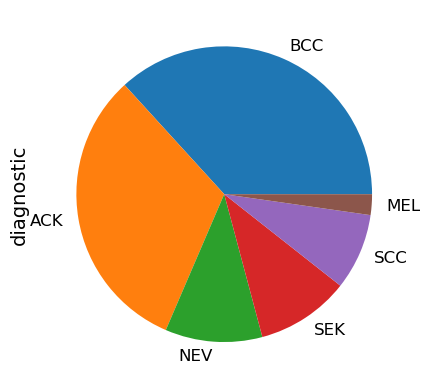

In [4]:
df["diagnostic"].value_counts().plot.pie();

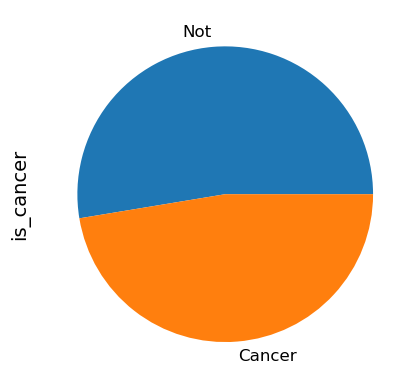

In [5]:
df['is_cancer'] = df['diagnostic'].apply(lambda s: "Cancer" if s in ["MEL", "BCC", "SCC"] else "Not")
df["is_cancer"].value_counts().plot.pie();

In [3]:
x_train, x_test, y_train, y_test = get_train_test_images_raw()

In [4]:
MulticlassEnconder = OneHotEncoder(sparse=False)
BinaryClassEnconder = OneHotEncoder(sparse=False)
Y = MulticlassEnconder.fit_transform(y_train)
Y_binary = BinaryClassEnconder.fit_transform(np.array(list(map(lambda x: "Cancer" if x in ['BCC', 'MEL', 'SCC'] else "Not", y_train))).reshape(-1,1))

2022-11-25 11:49:25.393657: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 361365504 exceeds 10% of free system memory.


15/15 [==============================] - 1s 80ms/step
              precision    recall  f1-score   support

         ACK       0.63      0.74      0.69       133
         BCC       0.69      0.68      0.69       177
         MEL       0.60      0.23      0.33        13
         NEV       0.58      0.76      0.66        50
         SCC       0.35      0.18      0.24        44
         SEK       0.47      0.37      0.42        43

    accuracy                           0.62       460
   macro avg       0.55      0.50      0.50       460
weighted avg       0.60      0.62      0.60       460



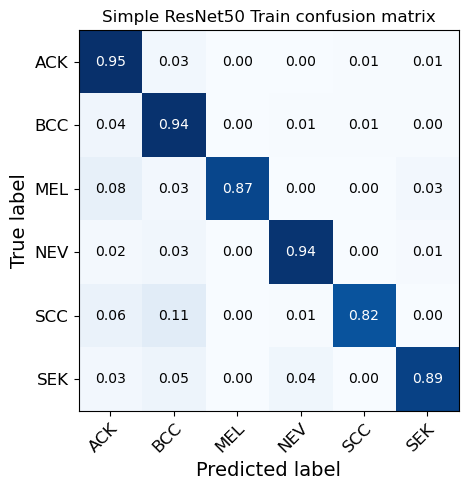

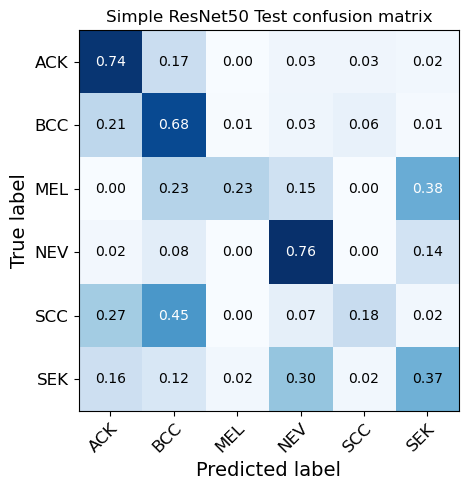

<Figure size 1000x500 with 0 Axes>

In [15]:
model = load_model(DATA_DIR / 'transf_1' / 'pad_ufes')
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
y_pred_classes = MulticlassEnconder.inverse_transform(y_pred_train).flatten()
y_true = y_train.flatten()
ax = plot_confusion_matrix(y_true=y_true, y_pred=y_pred_classes, classes=sorted(list(set(y_true))), cmap="Blues", title="Simple ResNet50 Train confusion matrix")
y_pred_classes = MulticlassEnconder.inverse_transform(y_pred_test).flatten()
y_true = y_test.flatten()
ax2 = plot_confusion_matrix(y_true=y_true, y_pred=y_pred_classes, classes=sorted(list(set(y_true))), cmap="Blues", title="Simple ResNet50 Test confusion matrix")
fig = plt.figure(figsize=(10,5))
fig.axes.append(ax)
fig.axes.append(ax2)
fig.show()
print(classification_report(y_true, y_pred_classes))

15/15 [==============================] - 1s 38ms/step
              precision    recall  f1-score   support

      Cancer       0.79      0.71      0.75       234
         Not       0.73      0.80      0.76       226

    accuracy                           0.75       460
   macro avg       0.76      0.76      0.75       460
weighted avg       0.76      0.75      0.75       460



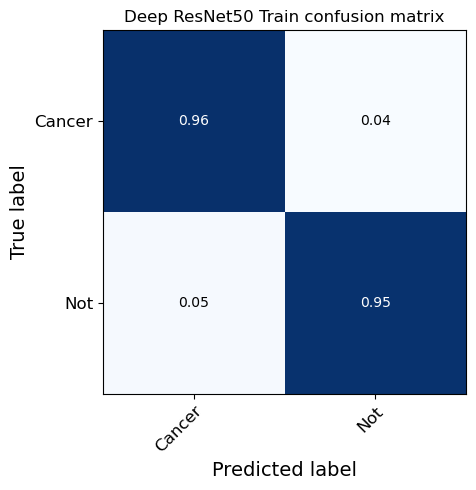

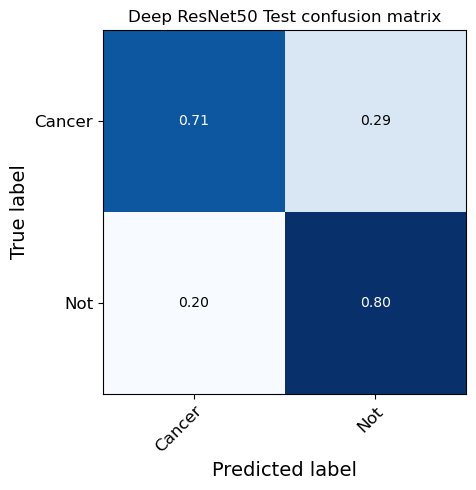

<Figure size 1000x500 with 0 Axes>

In [19]:
model_bin = load_model(DATA_DIR / 'transf_2' / 'pad_ufes')
y_pred_train = model_bin.predict(x_train)
y_pred_test = model_bin.predict(x_test)
y_pred_classes = BinaryClassEnconder.inverse_transform(y_pred_train).flatten()
y_true = list(map(lambda x : "Cancer" if x in ["MEL", "SCC", "BCC"] else "Not", y_train.flatten()))
ax = plot_confusion_matrix(y_true=y_true, y_pred=y_pred_classes, classes=sorted(list(set(y_true))), cmap="Blues", title="Deep ResNet50 Train confusion matrix")
y_pred_classes = BinaryClassEnconder.inverse_transform(y_pred_test).flatten()
y_true = list(map(lambda x : "Cancer" if x in ["MEL", "SCC", "BCC"] else "Not", y_test.flatten()))
ax2 = plot_confusion_matrix(y_true=y_true, y_pred=y_pred_classes, classes=sorted(list(set(y_true))), cmap="Blues", title="Deep ResNet50 Test confusion matrix")
fig = plt.figure(figsize=(10,5))
fig.axes.append(ax)
fig.axes.append(ax2)
fig.show()
print(classification_report(y_true, y_pred_classes))